# **1 - RNN (*Recurrent Neural Networks*)**

##  Introduction

**Recurrent neural networks (RNNs)** are a type of neural network which are used for dealing with sequencial data, such as text or speech. Their main difference with respect feed-forward neural networks is they use the output of the previous steps as input of the current step in the sequence, by using what is called a *hidden state*. This gives RNNs the ability to maintain a memory of previous inputs and model the temporal dependencies within sequential data, which is important for many applications in natural language processing, speech recognition, and more.

Their basic architecture is shown in the following figure:

<p align="left">
<img src="https://editor.analyticsvidhya.com/uploads/17464JywniHv.png"/>
</p>

*Figure 1: [A Brief Overview of Recurrent Neural Networks](https://www.analyticsvidhya.com/blog/2022/03/a-brief-overview-of-recurrent-neural-networks-rnn/), Analytics Vidhya*

In a feed-forward neural network, all the inputs and outputs are independent of each other. However, is some contexts, as happens with text, different inputs are related to each other. For that reason, a feed-forward neural network will not perform well. This is where RNNs come into play. As it is shown in the figure above, the output of a given timestamp $O_t$ depends on its corresponding input $X_t$ and in the outputs of all previous timestamps ($O_{t-1}$, $O_{t-2}$, etc).

However, the RNNs have a main disadvantage: if dealing with high sequences, the gradients may become too small or too large. This is commonly known as the Vanishing and Exploding Gradient Descent problems. *Vanishing Gradient Descent* makes the network not to reach the most optimal solution, getting stuck in a local minimum. On the other hand, *Exploding Gradient Descent* leads the model to diverge and never converge to an optimal solution. As we will show in following notebooks, other models such as LSTMs can solve this problem.

Let's load the required libraries in order to run the code:

In [1]:
import os

import pandas as pd
import numpy as np
# import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from src.data_preprocessing import train_test_split
from src.utils import plot_metric_curves

## Load dataset

Now let's load the dataset generated in `0-EDA.ipynb`:

In [2]:
dataset = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.csv")

df = pd.read_csv(dataset, sep=";")
df.head()

,headline,label
0,thirtysomething scientist unveil doomsday cloc...,1
1,dem rep totally nail congress falling short ge...,0
2,eat veggie deliciously different recipe,0
3,inclement weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


## Split data into train and test sets

We need to generate both training and test sets. We will use 80% of the data for training and the remaining 20% for testing. Moreover, in classification tasks it is important to maintain the same proportion of classes in both training and test sets (otherwise, the model might be affected by it during the training process, and the validation metrics may also be distorted). `scikit-learn` offers the class `StratifiedShuffleSplit` for achieving this, which will be used. We have developed the `train_test_split` function, which is stored in `src/data_preprocessing.py`:

In [3]:
X_train, y_train, X_test, y_test = train_test_split(df, "label")

Let's check that the training set contains 80% of data:

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Let's also check that the distribution of classes in both sets are almost the same:

In [5]:
y_train.value_counts(normalize=True)

0    0.524518
1    0.475482
Name: label, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.524469
1    0.475531
Name: label, dtype: float64

# Tokenization, Padding and Sequencing

In NLP, tokenization refers to the process of splitting a text into smaller units, which can be words, characters, or even groups of words known as n-grams. Each unit is then assigned an index to represent it. This allows us to transform a piece of text into a sequence of numbers that a machine learning model can understand.

However, not all units in the text may be found in the vocabulary that we have available, particularly in cases where the data used for training does not cover all possible words or expressions. In these situations, the units that are not present in the vocabulary are replaced with a special token called `OOV` (*Out of Vocabulary*) to indicate that they are unknown. This ensures that the model can still process the text and make predictions even if it encounters unfamiliar words.

***Note***: *in following notebooks the shown steps will be executed directly by using functions contained in `src/data_preprocessing.py`*.

**Source**: *Bala Priya C., [Tokenization and Sequencing in TensorFlow](https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n)*

In [7]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Train tokenizer on training data
tokenizer.fit_on_texts(X_train["headline"])

Let's see the vocabulary size:

In [8]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

22499

Once we have tokenized our text, we need to use the generated tokens to convert the headlines into sequences:

In [9]:
train_sequences = tokenizer.texts_to_sequences(X_train["headline"])
test_sequences = tokenizer.texts_to_sequences(X_test["headline"])

Let's see the first sequences in order to have a better idea of how these look like:

In [10]:
# Original headlines
X_train["headline"].values.tolist()[:3]

['still processing ending walking dead stranger',
 'legionnaire disease kill seven sickens new york city',
 'could family escape house fire time']

In [11]:
# Sequences
train_sequences[:3]

[[32, 8384, 1961, 571, 101, 931],
 [6636, 1138, 213, 4744, 8385, 3, 203, 120],
 [39, 34, 1327, 23, 145, 12]]

As it can be noticed, since each headline has a different length, each sequence has also a different length. However, in order to feed the data into the neural network, all the sequences must have the same length. Therefore, we will need to apply some kind of transformation to these sequences to make them all have the same length. For doing so, we will apply a technique called **padding**. Similar to what is seen in image processing, padding can be applied to text. In this case, we need to add a certain number of zeros at the beginning or at the end of each sequence, so all of them have the same length. Specifically, the length of the sequences will be the lenght of the largest sequence in the dataset. In our case, we will add zeros at the end of each sequence.

Let's first get the lenght of the longest sequence:

In [12]:
max_seq_len = max([len(seq) for seq in train_sequences])
max_seq_len

106

And now let's apply padding to the sequences:

In [13]:
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

Let's see the first sequences after applying padding, so we can compare these with how they looked like before:

In [14]:
# Sequences after padding
train_padded[:3]

array([[  32, 8384, 1961,  571,  101,  931,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [6636, 1138,  213, 4744, 8385,    3,  203,  120,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

It can be noticed that now all the sequences have the same length, which is exactly what we needed before feeding the data into our model.

## Build the model

We will build a simple model as it is shown below. The reason behind this is is because otherwise the model will tend to overfit quickly, and that might lead to a model which will not perform well with new data. Therefore, it is crucial to control overfitting as much as possible (also, because the model is trained using `EarlyStopping`, the model will be saved before it starts to overfit excessively).

In [15]:
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_seq_len))

# Add SimpleRNN layer
model.add(SimpleRNN(128))

# Flatten and Dense Layer
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [16]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 50)           1124950   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               22912     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,156,183
Trainable params: 1,156,183
Non-

## Train the model

Let's first create a folder where to save our models.

In [18]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [19]:
# Model name and path
model_path = os.path.join("models", "rnn_model.h5")

We use `EarlyStopping` to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e.: we will stop after there is no improvement in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs, as we can be fairly sure that training will be stopped before reaching the limit.

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [21]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(test_padded, np.array(y_test)),
    callbacks = [es, mc]
)

Epoch 1/30
357/357 [==============================] - ETA: 0s - loss: 0.7059 - acc: 0.5071
Epoch 1: val_loss improved from inf to 0.69585, saving model to models\rnn_model.h5
357/357 [==============================] - 13s 33ms/step - loss: 0.7059 - acc: 0.5071 - val_loss: 0.6958 - val_acc: 0.5245
Epoch 2/30
357/357 [==============================] - ETA: 0s - loss: 0.6997 - acc: 0.5065
Epoch 2: val_loss did not improve from 0.69585
357/357 [==============================] - 13s 37ms/step - loss: 0.6997 - acc: 0.5065 - val_loss: 0.7083 - val_acc: 0.4755
Epoch 3/30
357/357 [==============================] - ETA: 0s - loss: 0.6970 - acc: 0.5100
Epoch 3: val_loss improved from 0.69585 to 0.69311, saving model to models\rnn_model.h5
357/357 [==============================] - 14s 38ms/step - loss: 0.6970 - acc: 0.5100 - val_loss: 0.6931 - val_acc: 0.5245
Epoch 4/30
356/357 [============================>.] - ETA: 0s - loss: 0.6946 - acc: 0.5168
Epoch 4: val_loss did not improve from 0.69311
3

## Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

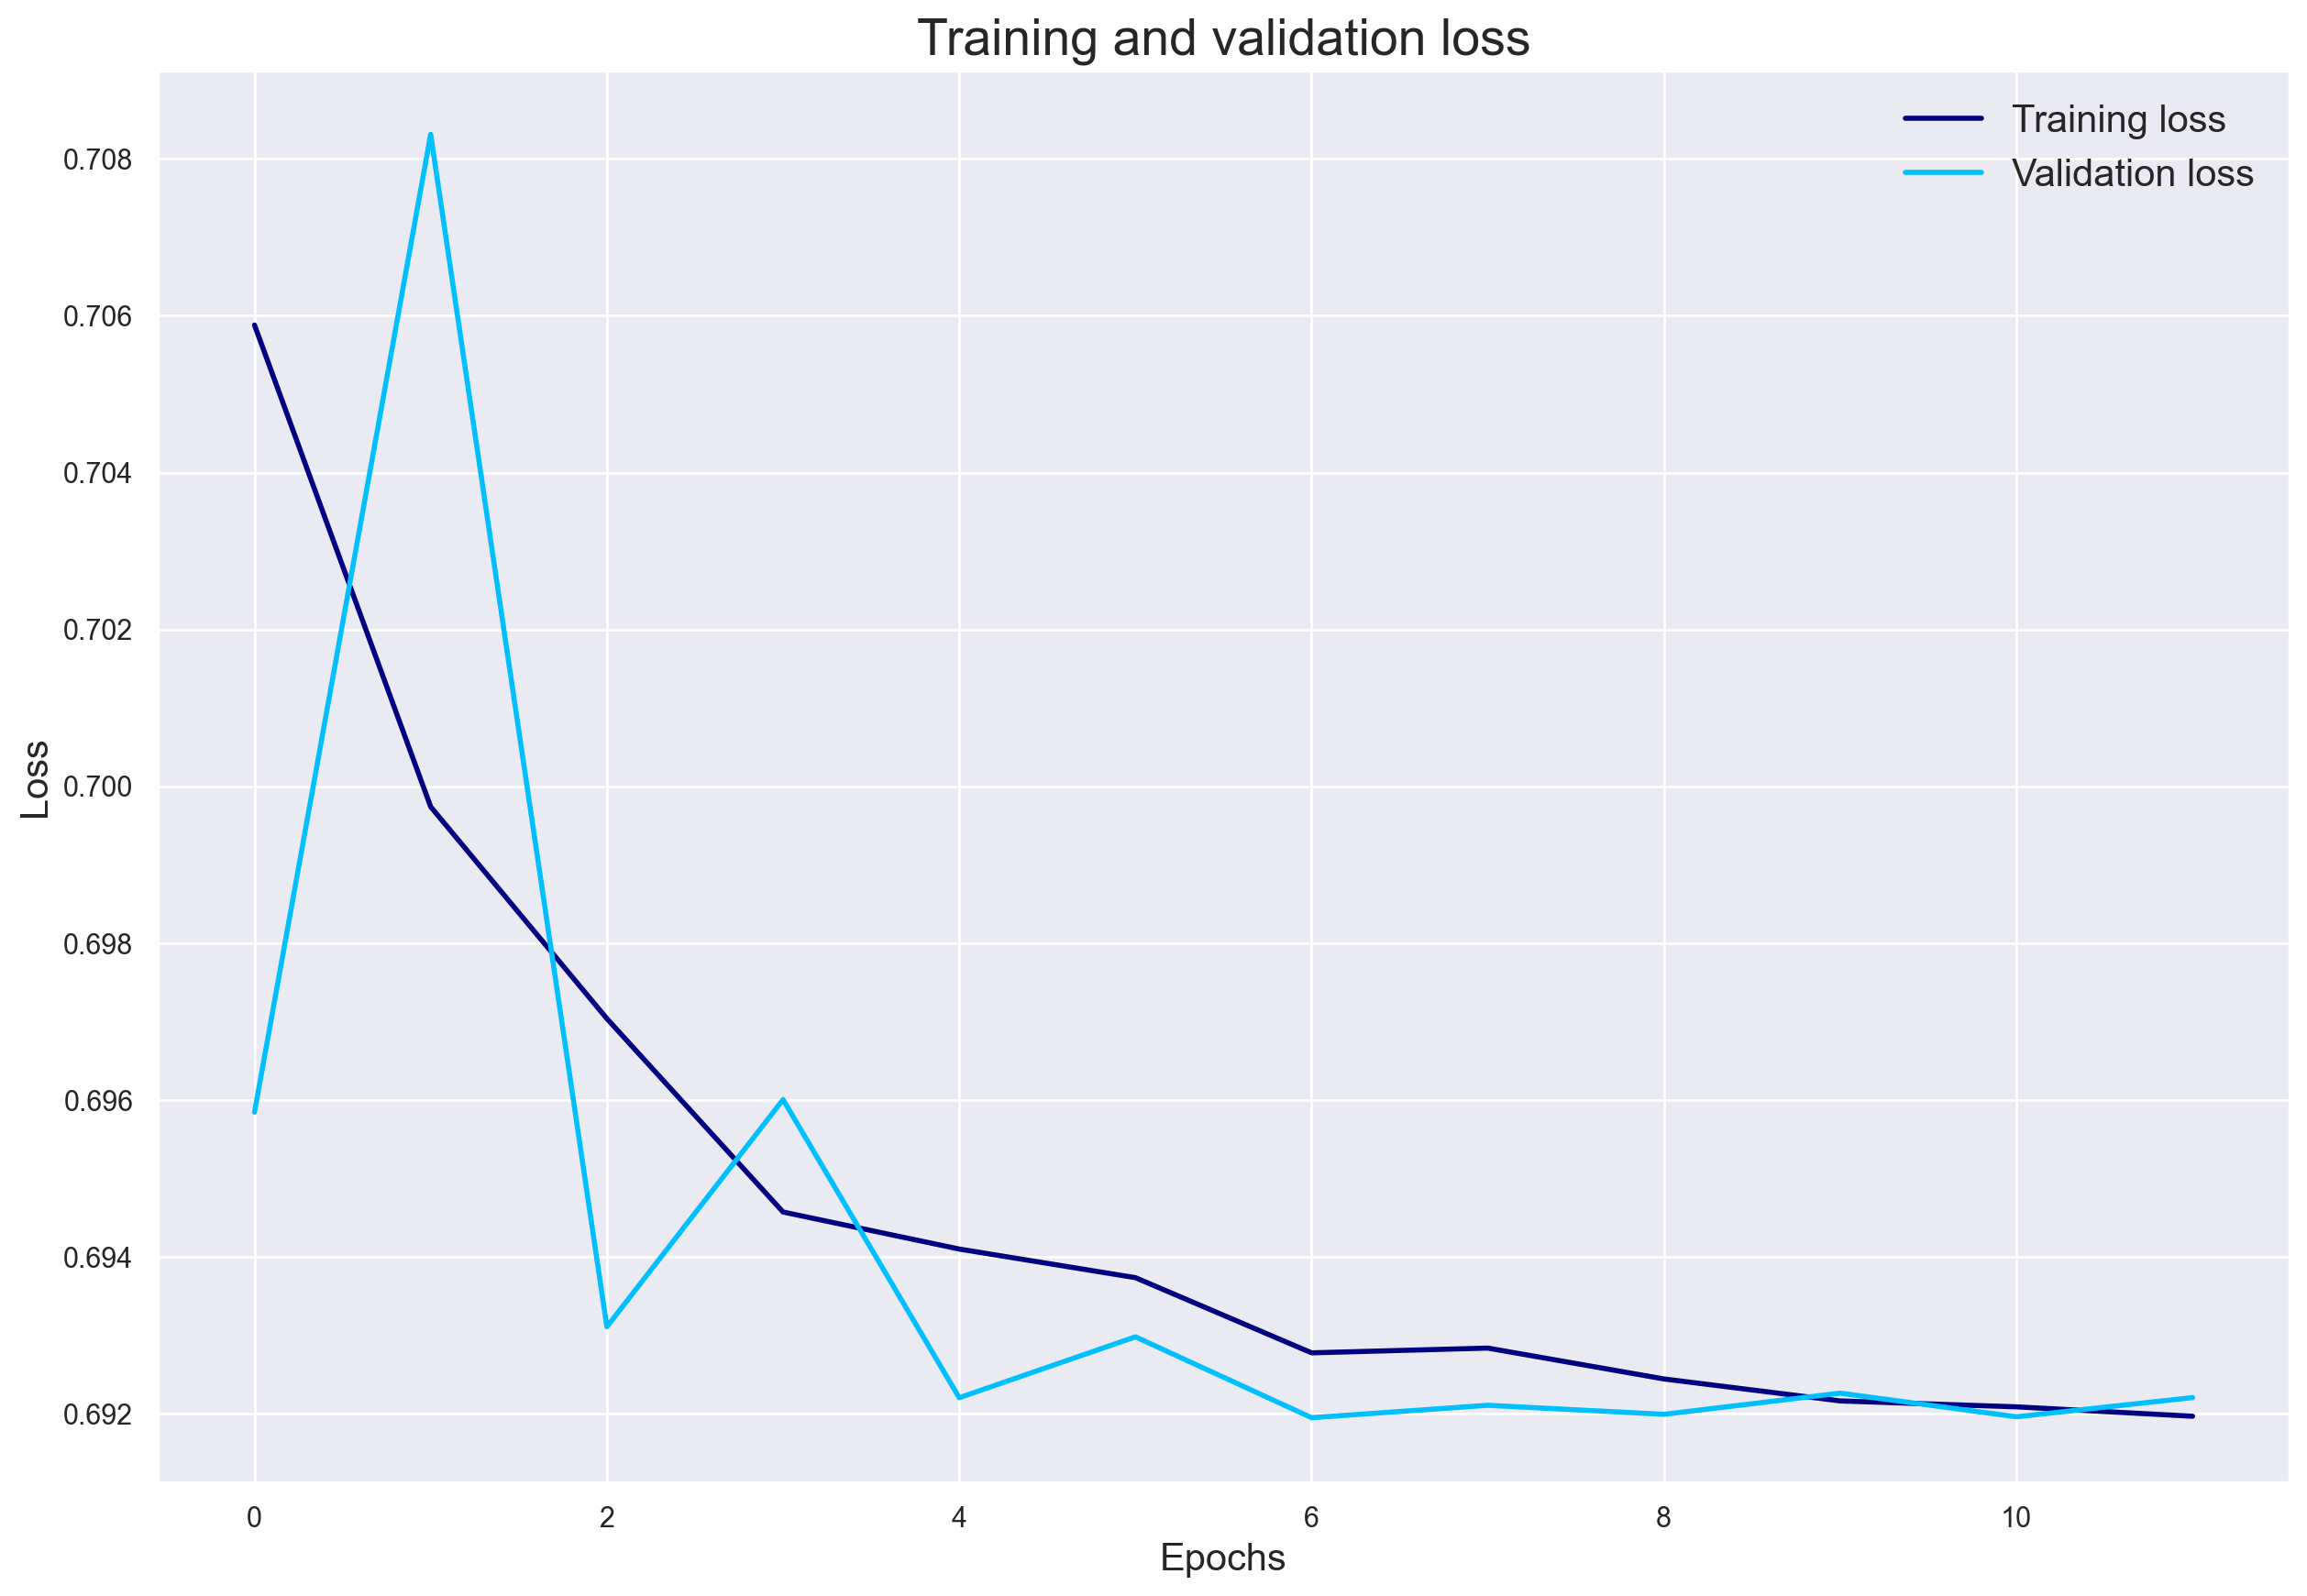

In [23]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss")

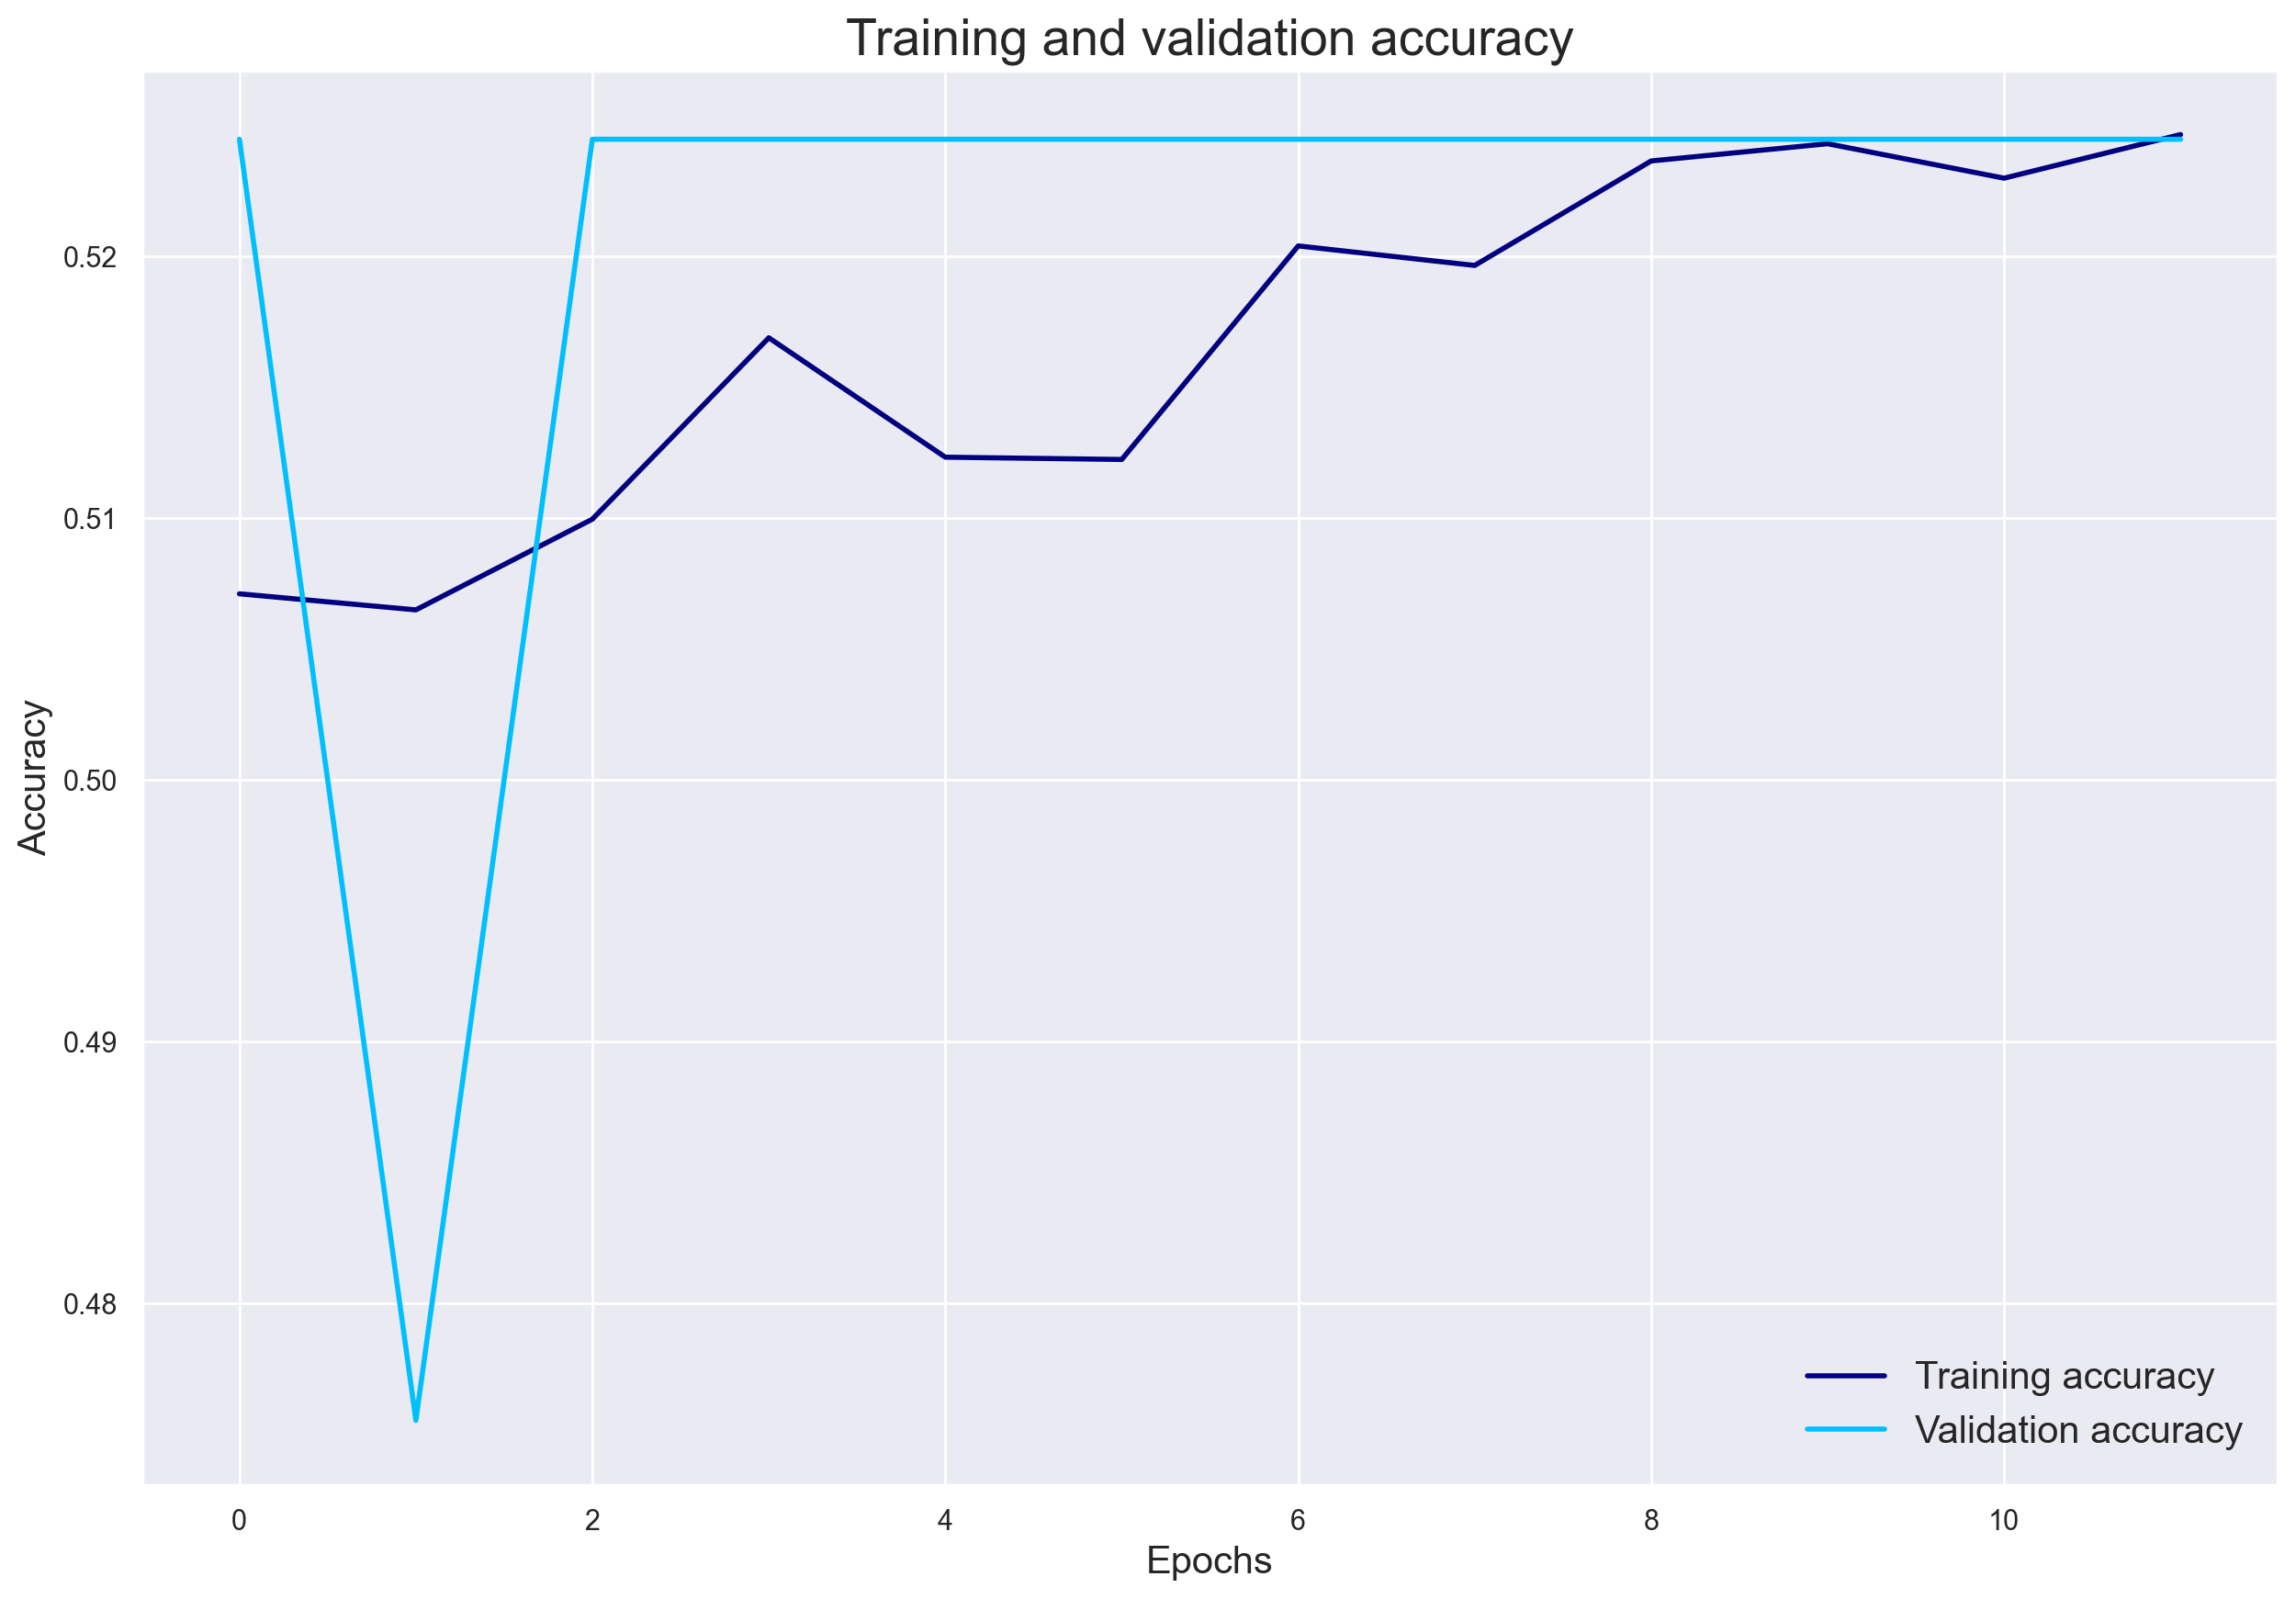

In [24]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy")

*Comment results obtained*